In [ ]:
from PIL import Image
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
#from torchvision.models import ResNet50_Weights
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
import matplotlib.pyplot as plt
import torchvision
from torchvision.transforms import functional as F
import torch
from tqdm import tqdm
import json
import pandas as pd

COCO_LBL_NAMES = {
    0: "unlabeled",
    1: "person",
    2: "bicycle",
    3: "car",
    4: "motorcycle",
    5: "airplane",
    6: "bus",
    7: "train",
    8: "truck",
    9: "boat",
    10: "traffic",
    11: "fire",
    12: "street",
    13: "stop",
    14: "parking",
    15: "bench",
    16: "bird",
    17: "cat",
    18: "dog",
    19: "horse",
    20: "sheep",
    21: "cow",
    22: "elephant",
    23: "bear",
    24: "zebra",
    25: "giraffe",
    26: "hat",
    27: "backpack",
    28: "umbrella",
    29: "shoe",
    30: "eye",
    31: "handbag",
    32: "tie",
    33: "suitcase",
    34: "frisbee",
    35: "skis",
    36: "snowboard",
    37: "sports",
    38: "kite",
    39: "baseball",
    40: "baseball",
    41: "skateboard",
    42: "surfboard",
    43: "tennis",
    44: "bottle",
    45: "plate",
    46: "wine",
    47: "cup",
    48: "fork",
    49: "knife",
    50: "spoon",
    51: "bowl",
    52: "banana",
    53: "apple",
    54: "sandwich",
    55: "orange",
    56: "broccoli",
    57: "carrot",
    58: "hot",
    59: "pizza",
    60: "donut",
    61: "cake",
    62: "chair",
    63: "couch",
    64: "potted",
    65: "bed",
    66: "mirror",
    67: "dining",
    68: "window",
    69: "desk",
    70: "toilet",
    71: "door",
    72: "tv",
    73: "laptop",
    74: "mouse",
    75: "remote",
    76: "keyboard",
    77: "cell",
    78: "microwave",
    79: "oven",
    80: "toaster",
    81: "sink",
    82: "refrigerator",
    83: "blender",
    84: "book",
    85: "clock",
    86: "vase",
    87: "scissors",
    88: "teddy",
    89: "hair",
    90: "toothbrush",
    91: "hair",
    92: "banner",
    93: "blanket",
    94: "branch",
    95: "bridge",
    96: "building",
    97: "bush",
    98: "cabinet",
    99: "cage",
    100: "cardboard",
    101: "carpet",
    102: "ceiling",
    103: "ceiling",
    104: "cloth",
    105: "clothes",
    106: "clouds",
    107: "counter",
    108: "cupboard",
    109: "curtain",
    110: "desk",
    111: "dirt",
    112: "door",
    113: "fence",
    114: "floor",
    115: "floor",
    116: "floor",
    117: "floor",
    118: "floor",
    119: "flower",
    120: "fog",
    121: "food",
    122: "fruit",
    123: "furniture",
    124: "grass",
    125: "gravel",
    126: "ground",
    127: "hill",
    128: "house",
    129: "leaves",
    130: "light",
    131: "mat",
    132: "metal",
    133: "mirror",
    134: "moss",
    135: "mountain",
    136: "mud",
    137: "napkin",
    138: "net",
    139: "paper",
    140: "pavement",
    141: "pillow",
    142: "plant",
    143: "plastic",
    144: "platform",
    145: "playingfield",
    146: "railing",
    147: "railroad",
    148: "river",
    149: "road",
    150: "rock",
    151: "roof",
    152: "rug",
    153: "salad",
    154: "sand",
    155: "sea",
    156: "shelf",
    157: "sky",
    158: "skyscraper",
    159: "snow",
    160: "solid",
    161: "stairs",
    162: "stone",
    163: "straw",
    164: "structural",
    165: "table",
    166: "tent",
    167: "textile",
    168: "towel",
    169: "tree",
    170: "vegetable",
    171: "wall",
    172: "wall",
    173: "wall",
    174: "wall",
    175: "wall",
    176: "wall",
    177: "wall",
    178: "water",
    179: "waterdrops",
    180: "window",
    181: "window",
    182: "wood"
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# TODO se io genero un adv img con la backbone e una head di classificazione poi magari uso la head per metric o obj detection dove le head cambiano verificare quanto l adv folla cioè quanto è basata a fregare la backbone piuttosto che gli ultimi layer
# TODO Inoltre puoi verificare come l adv (creata dalla net pretrained) si comporta su una net finetunnata per task simili 

# Utils

In [144]:
class DatasetCustomLabel(Dataset):
    def __init__(self, root_dir, label, transform=None):
        self.img_dir = os.path.join(root_dir, 'val2017')
        self.img_names = [f for f in os.listdir(self.img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.label = label
        self.transform = transform

        gt_path = os.path.join(LABEL_PATH)
        with open(gt_path, 'r') as f:
            gt_json = json.load(f)
        images_df = pd.DataFrame(gt_json['images'])
        annotations_df = pd.DataFrame(gt_json['annotations'])
        self.pd_gt = pd.merge(annotations_df, images_df)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        bboxes = self.pd_gt[self.pd_gt['file_name'] == self.img_names[idx]]['bbox'].tolist()
        return image, self.label, bboxes

In [51]:
def get_adv_car_dataset(data_root, attack_type, label, transform):
    data_path = f'{data_root}/car/vehicle_{attack_type}_entire/'
    dataset = DatasetCustomLabel(data_path, label, transform=transform)
    return dataset

# PADetBench

In [145]:
DATA_ROOT = f'/mnt/ssd1t/datasets/PADetBench/generated_datasets_PADetBench'
LABEL_PATH = f'{DATA_ROOT}/car/vehicle_clean_entire/annotations/instances_val2017.json'
LABEL = "car"
IDX_LABEL = 3
DETECTION_THRESHOLD = 0.5
ATTACK_TYPES = ["3d2fool", 'active', 'appa', 'camou', 'dta', 'fca', 'poopatch', 'random', 'rpau']
transform = FasterRCNN_ResNet50_FPN_Weights.COCO_V1.transforms()

## Dataset Exploration

- Attack types
- Len
- Show fail case

In [128]:
dataset = get_adv_car_dataset(DATA_ROOT, "clean", LABEL, transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
print('Dataset length:', len(dataloader))

Dataset length: 700


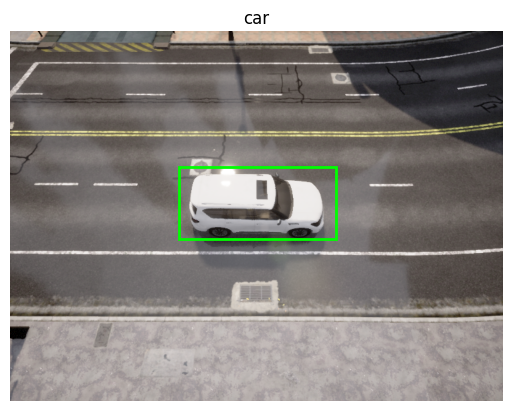

In [129]:
idx_sample = 65
sample = dataset[idx_sample][0]
bboxes = dataset[idx_sample][2]

ax = plt.gca()
for bbox in bboxes:
    x, y, w, h = bbox
    rect = plt.Rectangle((x, y), w, h, fill=False, color='lime', linewidth=2)
    ax.add_patch(rect)

img = sample.permute(1, 2, 0).cpu().numpy()
plt.imshow(img)
plt.title(dataset[idx_sample][1])
plt.axis('off')
plt.show()

# Inference

In [5]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
model.to(device)
model = model.eval()

## Show Bounding Box 

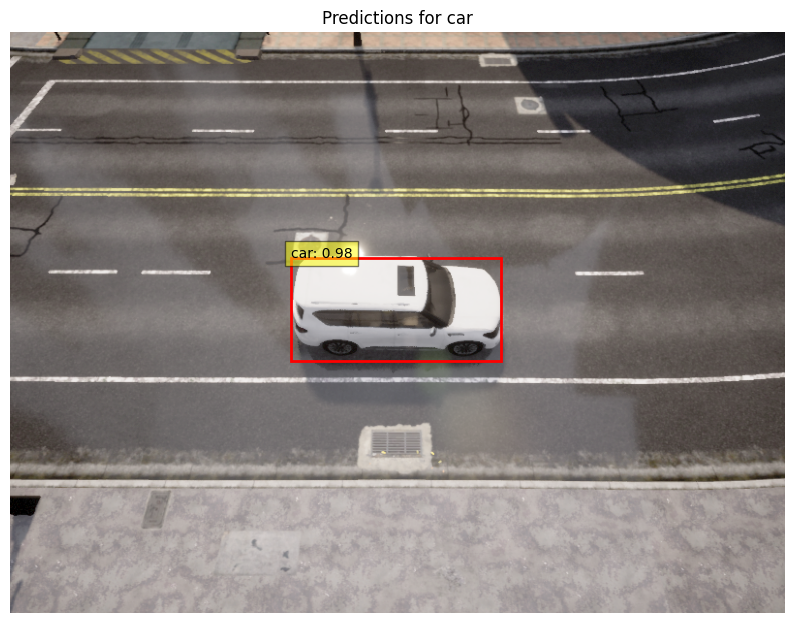

In [49]:
image, label = dataset[idx_sample]
image = image.unsqueeze(0).to(device)

with torch.no_grad():
    prediction = model(image)

img = image.squeeze(0).permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(img)
ax = plt.gca()

for box, score, label in zip(prediction[0]['boxes'], prediction[0]['scores'], prediction[0]['labels']):
    if score > DETECTION_THRESHOLD:
        x1, y1, x2, y2 = box.tolist()
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        label_name = COCO_LBL_NAMES[label.item()]
        ax.text(x1, y1, f'{label_name}: {score:.2f}', bbox={'facecolor': 'yellow', 'alpha': 0.5})

plt.title(f"Predictions for {dataset[idx_sample][1]}")
plt.axis('off')
plt.show()

## Evaluation

In [130]:
def evaluation(dataloader, model):
    predictions = []
    with torch.no_grad():
        for images, _, _ in tqdm(dataloader):
            images = images.to(device)
            pred = model(images)
            predictions.append(pred)
    return predictions

def get_accuracy(predictions, dataloader):
    correct = 0
    no_detection = 0
    total = len(dataloader)

    for preds in predictions:
        pred_labels = preds[0]['labels']
        pred_scores = preds[0]['scores']
        
        # skip if no prediction
        if len(pred_labels) == 0:
            no_detection += 1
            continue  
        
        person_idxs = torch.where(pred_labels == IDX_LABEL)[0]
        # skip if no person prediction
        if len(person_idxs) == 0:
            no_detection += 1
            continue 

        # TODO check if the most probable thing is in the first position
        if (pred_scores[person_idxs[0]]) > DETECTION_THRESHOLD:
            correct += 1

    accuracy = correct / total
    return accuracy, no_detection, total

In [158]:
dataset = get_adv_car_dataset(DATA_ROOT, "clean", LABEL, transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False) # Use batch_size=1 for evaluation

predictions = evaluation(dataloader, model)
accuracy, no_detection, total = get_accuracy(predictions, dataloader)
print(f"Accuracy: {accuracy:.4f}")
print(f"No detection: {no_detection} out of {total} images")

100%|██████████| 700/700 [01:35<00:00,  7.30it/s]


Accuracy: 0.7757
No detection: 56 out of 700 images


Active attack: folla propro la detection, non trova nemmeno i BB
Checkare gli altri: 
- alcuni trovano car ma con bassa confidence
- alcuni sbaglaino la classificazione

In [ ]:
for attack_type in ATTACK_TYPES:
    dataset = get_adv_car_dataset(DATA_ROOT, attack_type, LABEL, transform)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False) # Use batch_size=1 for evaluation

    predictions = evaluation(dataloader, model)
    accuracy, no_detection, total = get_accuracy(predictions, dataloader)
    print(f"[{attack_type}] Accuracy: {accuracy:.4f}")
    print(f"[{attack_type}] No detection: {no_detection} out of {total} images")

100%|██████████| 700/700 [01:35<00:00,  7.33it/s]


[3d2fool] Accuracy: 0.6214
[3d2fool] No detection: 67 out of 700 images


100%|██████████| 700/700 [01:36<00:00,  7.28it/s]


[active] Accuracy: 0.2500
[active] No detection: 311 out of 700 images


100%|██████████| 700/700 [01:36<00:00,  7.25it/s]


[appa] Accuracy: 0.5757
[appa] No detection: 84 out of 700 images


100%|██████████| 700/700 [01:35<00:00,  7.29it/s]


[camou] Accuracy: 0.4486
[camou] No detection: 164 out of 700 images


100%|██████████| 700/700 [01:36<00:00,  7.27it/s]


[dta] Accuracy: 0.4029
[dta] No detection: 170 out of 700 images


100%|██████████| 700/700 [01:36<00:00,  7.28it/s]


[fca] Accuracy: 0.4886
[fca] No detection: 178 out of 700 images


100%|██████████| 700/700 [01:36<00:00,  7.26it/s]


[poopatch] Accuracy: 0.3871
[poopatch] No detection: 227 out of 700 images


100%|██████████| 700/700 [01:36<00:00,  7.25it/s]


[random] Accuracy: 0.5029
[random] No detection: 107 out of 700 images


100%|██████████| 700/700 [01:35<00:00,  7.30it/s]

[rpau] Accuracy: 0.4457
[rpau] No detection: 190 out of 700 images


In [173]:
dataset = get_adv_car_dataset(DATA_ROOT, "active", LABEL, transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False) # Use batch_size=1 for evaluation

predictions_active = evaluation(dataloader, model)
#accuracy, no_detection, total = get_accuracy(predictions, dataloader)
#print(f"[{attack_type}] Accuracy: {accuracy:.4f}")
#print(f"[{attack_type}] No detection: {no_detection} out of {total} images")

100%|██████████| 700/700 [01:36<00:00,  7.26it/s]


# ASR metric

In [170]:
import numpy as np
import pandas as pd
from collections import defaultdict

def compute_iou(boxA, boxB):
    # Compute Intersection over Union
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def compute_ar_per_image(gt_boxes, pred_boxes, iou_threshold=0.5):
    """
    Compute recall per image: proportion of GT boxes correctly detected
    """
    matched_gt = set()
    pred_boxes_sorted = sorted(pred_boxes, key=lambda x: -x[4])  # sort by score descending
    for pred in pred_boxes_sorted:
        if pred[4] < DETECTION_THRESHOLD:
            continue
        pred_box = pred[:4]
        for i, gt in enumerate(gt_boxes):
            if i in matched_gt:
                continue
            iou = compute_iou(gt, pred_box)
            if iou >= iou_threshold:
                matched_gt.add(i)
                break
    if len(gt_boxes) == 0:
        return 1.0 if len(pred_boxes) == 0 else 0.0
    return 1 - (len(matched_gt) / len(gt_boxes))

def compute_mAR50(dataset):
    """
    dataset: list of dicts with keys: image_id, gt_boxes, pred_boxes
    pred_boxes format: [x_min, y_min, x_max, y_max, score]
    gt_boxes format: [x_min, y_min, x_max, y_max]
    """
    recalls = []
    for sample in dataset:
        recall = compute_ar_per_image(sample['gt_boxes'], sample['pred_boxes'], iou_threshold=0.5)
        recalls.append(recall)
    return np.mean(recalls)

In [174]:
def dataset_to_dataframe(dataset, predictions):
    """
    Convert a torch Dataset to a pandas DataFrame.
    Assumes __getitem__ returns (image, label, bboxes).
    """
    records = []
    for idx in tqdm(range(len(dataset))):
        _, label, bboxes = dataset[idx]
        records.append({
            'idx': idx,
            'label': label,
            'gt_boxes': bboxes,
            'pred_boxes': [
                list(box) + [score.item()]
                for box, score in zip(
                    predictions[idx][0]['boxes'].cpu().numpy(),
                    predictions[idx][0]['scores'].cpu()
                )
            ] if predictions else [],
            #'pred_boxes': predictions[idx][0]['boxes'].cpu().numpy() if predictions else [],
        })
    return records

#df_dataset = dataset_to_dataframe(dataset, predictions)
df_dataset_active = dataset_to_dataframe(dataset, predictions_active)


100%|██████████| 700/700 [00:13<00:00, 52.19it/s]


In [169]:
df_dataset[0]['pred_boxes'][0]

[np.float32(301.80054),
 np.float32(175.57089),
 np.float32(489.9069),
 np.float32(390.48148),
 0.9719126224517822]

In [171]:
# OG
compute_mAR50(df_dataset)

np.float64(0.9385714285714286)

In [175]:
# Active
compute_mAR50(df_dataset_active)

np.float64(0.9471428571428572)

# YOLO

In [ ]:
from ultralytics import YOLO

# Load YOLOv3 model
yolo_model = YOLO('yolov5s.pt')
yolo_model.to(device)
yolo_model.eval()

yolo_predictions = []
with torch.no_grad():
    for images, _ in tqdm(dataloader):
        # YOLO expects numpy or PIL images, so revert transforms
        img = images[0].permute(1, 2, 0).cpu().numpy()
        img = (img * std) + mean
        img = np.clip(img * 255, 0, 255).astype(np.uint8)
        pil_img = Image.fromarray(img)
        results = yolo_model(pil_img)
        yolo_predictions.append(results)

# Calculate accuracy
yolo_correct = 0
yolo_total = len(yolo_predictions)
yolo_issue = 0

for i, results in enumerate(yolo_predictions):
    boxes = results[0].boxes
    if boxes is None or len(boxes) == 0:
        yolo_issue += 1
        continue
    # Get label with highest confidence
    person_idxs = torch.where(boxes.cls == 0)[0]
    if len(person_idxs) == 0:
        yolo_issue += 1
        continue  # skip if no person prediction

    # TODO check if the most probable thing is in the first position
    if (boxes.conf[person_idxs[0]]) > 0.7:
        yolo_correct += 1
    #max_idx = torch.argmax(boxes.conf)
    #pred_label = int(boxes.cls[max_idx].item())

    # COCO_LBL_NAMES for YOLO starts from 0, so mapping is direct
    #if COCO_LBL_NAMES[pred_label+1] == LABEL:  # YOLO class 0 is COCO 1
    #    yolo_correct += 1

yolo_accuracy = yolo_correct / yolo_total
print(f"YOLOv3 Accuracy: {yolo_accuracy:.4f}")
print(f"YOLOv3 Issue count: {yolo_issue}")

# Download AdvT-shirt

In [ ]:
# Script bash
# for i in $(seq -w 0 1350); do wget -nc "https://huggingface.co/datasets/xingjunm/AdvT-shirt/resolve/main/AdvT-shirt/1_person/images/${i}.jpg" -O /mnt/ssd1t/datasets/AdvT-shirt/${i}.jpg; done
# find /mnt/ssd1t/datasets/AdvT-shirt/1_person/ -type f -name "*.jpg" -size 0 -delete